In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import geopandas as gpd
from shapely.geometry import Point
import networkx as nx
from geopy.distance import geodesic
from tqdm import tqdm
from shapely.geometry import LineString
import heapq
import ipywidgets as widgets
from IPython.display import display, clear_output
from IPython.core.display import HTML

In [2]:
datapath = "../new_data/"

In [3]:
df = pd.read_csv(datapath+"Supercharge Locations.csv")
df_CA = df[df["State"]=="CA"]
df_CA = df_CA.drop(columns=["Unnamed: 11","Country","Open Date", "Elev(m)","State"])
df_CA.head()

,Supercharger,Street Address,City,Zip,Stalls,kW,GPS
0,"Buellton, CA",555 McMurray Rd,Buellton,93427,10,150.0,"34.61456, -120.188387"
1,"Corning, CA",950 Hwy 99,Corning,96021,6,150.0,"39.926454, -122.198393"
2,"Barstow, CA",2812 Lenwood Rd,Barstow,92311,16,150.0,"34.849129, -117.085446"
4,"Roseville, CA",1151 Galleria Blvd,Roseville,95678,7,150.0,"38.771208, -121.266149"
5,"Oxnard, CA",2751 Park View Ct,Oxnard,93036,20,150.0,"34.238654, -119.177398"
...,...,...,...,...,...,...,...
5744,"South San Francisco, CA",250 Gateway Blvd,South San Francisco,94080,20,72.0,"37.655243, -122.401321"
5750,"Hawthorne, CA",1 Rocket Rd,Hawthorne,90250,12,250.0,"33.921068, -118.330054"
5786,"Buena Park (SC), CA",6692 Auto Center Dr,Buena Park,90621,8,120.0,"33.863379, -117.99103"
5823,"San Diego - Del Mar Heights Rd, CA",Del Mar Heights Rd,San Diego,92130,18,72.0,"32.952645, -117.235974"


In [4]:
df_CA["kW"].unique()

array([150., 250., 125., 120.,  72.])

In [5]:
df_CA.info()

<class 'pandas.core.frame.DataFrame'>
Index: 496 entries, 0 to 5867
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Supercharger    496 non-null    object 
 1   Street Address  496 non-null    object 
 2   City            496 non-null    object 
 3   Zip             495 non-null    object 
 4   Stalls          496 non-null    int64  
 5   kW              496 non-null    float64
 6   GPS             496 non-null    object 
dtypes: float64(1), int64(1), object(5)
memory usage: 31.0+ KB


In [6]:
df_CA.at[df_CA[df_CA["Zip"].isnull()].index.values[0],"Zip"] = '91007'

In [7]:
df_CA['Latitude'] = None
df_CA['Longitude'] = None

df_CA[['Latitude', 'Longitude']] = df_CA['GPS'].str.split(', ', expand=True)

# Convert Latitude and Longitude to float if needed
df_CA['Latitude'] = df_CA['Latitude'].astype(float)
df_CA['Longitude'] = df_CA['Longitude'].astype(float)
df_CA.head()

,Supercharger,Street Address,City,Zip,Stalls,kW,GPS,Latitude,Longitude
0,"Buellton, CA",555 McMurray Rd,Buellton,93427,10,150.0,"34.61456, -120.188387",34.614560,-120.188387
1,"Corning, CA",950 Hwy 99,Corning,96021,6,150.0,"39.926454, -122.198393",39.926454,-122.198393
2,"Barstow, CA",2812 Lenwood Rd,Barstow,92311,16,150.0,"34.849129, -117.085446",34.849129,-117.085446
4,"Roseville, CA",1151 Galleria Blvd,Roseville,95678,7,150.0,"38.771208, -121.266149",38.771208,-121.266149
5,"Oxnard, CA",2751 Park View Ct,Oxnard,93036,20,150.0,"34.238654, -119.177398",34.238654,-119.177398
...,...,...,...,...,...,...,...,...,...
5744,"South San Francisco, CA",250 Gateway Blvd,South San Francisco,94080,20,72.0,"37.655243, -122.401321",37.655243,-122.401321
5750,"Hawthorne, CA",1 Rocket Rd,Hawthorne,90250,12,250.0,"33.921068, -118.330054",33.921068,-118.330054
5786,"Buena Park (SC), CA",6692 Auto Center Dr,Buena Park,90621,8,120.0,"33.863379, -117.99103",33.863379,-117.991030
5823,"San Diego - Del Mar Heights Rd, CA",Del Mar Heights Rd,San Diego,92130,18,72.0,"32.952645, -117.235974",32.952645,-117.235974


In [8]:
map_CA = folium.Map(location=[36.7783, -119.4179],
                       zoom_start=6)
for index, row in df_CA.iterrows():
    zip_code = row['Zip']
    stalls = row['Stalls']
    coordinates = row['GPS'].split(', ')
    kw = row['kW']
    lat, lon = float(coordinates[0]), float(coordinates[1])
    if kw == 250:
        marker_color = 'red'
    elif kw == 150:
        marker_color = 'blue'
    elif kw in [125, 120]:
        marker_color = 'gray'
    elif kw == 72:
        marker_color = 'beige'
    else:
        marker_color = 'green'
    folium.Marker([lat, lon],
                  popup=f"Zip: {zip_code},\nStalls: {stalls},\n{np.floor(kw).astype(int)} kW\n({lat},{lon})",
                  icon=folium.Icon(color=marker_color, icon='bolt', prefix='fa')).add_to(map_CA)
    
map_CA

In [9]:
min_lon = -122.7884 
max_lon = -120.0132
min_lat = 35.4865 
max_lat = 39.7266


# min_lon = -120.4346
# max_lon = -118.0784
# min_lat = 33.9867
# max_lat = 34.9530

# min_lon = -180
# max_lon = 180
# min_lat = -90
# max_lat = 90

In [10]:
df_road_edge = pd.read_csv(datapath+"cal_road_net_edge.csv")
df_road_node = pd.read_csv(datapath+"cal_road_network_node.csv")
# Since the original dataset had Latitude and Longitude reversed we will swap them
df_road_node['Latitude'], df_road_node['Longitude'] = df_road_node['Longitude'], df_road_node['Latitude']

df_road_edge.head()

,Sl,Node1,Node2,Distance
0,0,0,1,0.002025
1,1,0,6,0.005952
2,2,1,2,0.014350
3,3,2,3,0.012279
4,4,3,4,0.011099
...,...,...,...,...
21688,21688,21042,21043,0.003753
21689,21689,21043,21044,0.003599
21690,21690,21044,21045,0.013969
21691,21691,21044,21047,0.009922


In [11]:
df_road_node.head()

,Node,Latitude,Longitude
0,0,41.974556,-121.904167
1,1,41.974766,-121.902153
2,2,41.988075,-121.896790
3,3,41.998032,-121.889603
4,4,42.008739,-121.886681
...,...,...,...
21043,21043,32.550213,-117.042160
21044,21044,32.546886,-117.043533
21045,21045,32.553497,-117.055840
21046,21046,32.562462,-117.067970


In [12]:
def limit_coordinates(df, min_lat, max_lat, min_long, max_long):
    # Limit latitude
    df = df[(df['Latitude'] >= min_lat) & (df['Latitude'] <= max_lat)]

    # Limit longitude
    df = df[(df['Longitude'] >= min_long) & (df['Longitude'] <= max_long)]
    return df

df_charger = limit_coordinates(df_CA, min_lat, max_lat, min_lon, max_lon).reset_index()
df_nodes = limit_coordinates(df_road_node, min_lat, max_lat, min_lon, max_lon).reset_index()

df_edges = df_road_edge[df_road_edge["Node1"].isin(df_nodes.Node.to_list()) &
                        df_road_edge["Node2"].isin(df_nodes.Node.to_list())].drop(columns=["Sl"]).reset_index()
df_charger = df_charger.drop(columns="index")
df_nodes = df_nodes.drop(columns="index")
df_edges = df_edges.drop(columns="index")

In [13]:
df_charger.head()

,Supercharger,Street Address,City,Zip,Stalls,kW,GPS,Latitude,Longitude
0,"Buellton, CA",555 McMurray Rd,Buellton,93427,10,150.0,"34.61456, -120.188387",34.614560,-120.188387
1,"Oxnard, CA",2751 Park View Ct,Oxnard,93036,20,150.0,"34.238654, -119.177398",34.238654,-119.177398
2,"Santa Barbara, CA",3943 State St,Santa Barbara,93105,16,250.0,"34.440227, -119.753359",34.440227,-119.753359
3,"Goleta, CA",7004 Market Pl Dr,Goleta,93117,12,250.0,"34.427015, -119.871768",34.427015,-119.871768
4,"Santa Clarita, CA",23975 Newhall Ranch Rd,Santa Clarita,91355,32,250.0,"34.431041, -118.554319",34.431041,-118.554319
...,...,...,...,...,...,...,...,...,...
63,"Burbank - E Orange Grove Ave, CA",133 E Orange Grove Ave,Burbank,91502,28,250.0,"34.1813, -118.3107",34.181300,-118.310700
64,"Santa Clarita - Newhall Ranch Rd, CA",28273 Newhall Ranch Rd,Santa Clarita,91355,24,250.0,"34.441547, -118.577621",34.441547,-118.577621
65,"Santa Clarita - Magic Mountain Pkwy, CA",24235 Magic Mountain Pkwy,Santa Clarita,91355,16,250.0,"34.41895, -118.559089",34.418950,-118.559089
66,"Chatsworth - Mason Ave, CA",9825 Mason Ave,Chatsworth,91311,20,250.0,"34.248337, -118.580016",34.248337,-118.580016


In [14]:
df_charger["kW"].unique()

array([150., 250.,  72., 120.])

In [15]:
df_nodes.head()

,Node,Latitude,Longitude
0,15237,34.946918,-120.433487
1,15238,34.941998,-120.428612
2,15239,34.939190,-120.428589
3,15240,34.933487,-119.508163
4,15241,34.936329,-119.477669
...,...,...,...
1289,18163,33.996593,-118.082550
1290,18166,34.017471,-118.157440
1291,18167,33.997597,-118.135513
1292,18192,34.008308,-118.166206


In [16]:
df_edges.head()

,Node1,Node2,Distance
0,15237,15238,0.006927
1,15238,15239,0.002808
2,15239,15269,0.003245
3,15240,15241,0.030627
4,15240,15254,0.013047
...,...,...,...
1330,18077,18078,0.007301
1331,18078,18134,0.005316
1332,18148,18149,0.029665
1333,18166,18167,0.029594


In [17]:
reduced_map = folium.Map(location=[35, -119], zoom_start=6)
for index, row in df_charger.iterrows():
    zip_code = row['Zip']
    stalls = row['Stalls']
    coordinates = row['GPS'].split(', ')
    kw = row['kW']
    lat, lon = float(coordinates[0]), float(coordinates[1])
    if kw == 250:
        marker_color = 'red'
    elif kw == 150:
        marker_color = 'blue'
    elif kw in [120, 122, 125, 120]:
        marker_color = 'gray'
    elif kw == 72:
        marker_color = 'beige'
    else:
        marker_color = 'green'
    folium.Marker([lat, lon],
                  popup=f"Zip: {zip_code},\nStalls: {stalls},\n{np.floor(kw).astype(int)} kW\n({lat},{lon})",
                  icon=folium.Icon(color=marker_color, icon='bolt', prefix='fa')).add_to(reduced_map)
    
reduced_map

In [18]:
G = nx.Graph()
for index, row in df_nodes.iterrows():
    G.add_node(row['Node'],
               pos=(row['Longitude'], row['Latitude']))
    
for index, row in df_edges.iterrows():
    G.add_edge(row['Node1'], row['Node2'],
               weight = row['Distance'])

In [20]:
charger_points = gpd.GeoDataFrame(df_charger,
                                  geometry=gpd.points_from_xy(df_charger['Longitude'], df_charger['Latitude']))

In [21]:
node_to_charger = []

for node in tqdm(G.nodes, desc="Processing nodes"):
    node_coords = df_nodes.loc[df_nodes['Node'] == node,
                               ['Latitude', 'Longitude']].values.flatten()
    
    nearest_charger_distance = float('inf')
    nearest_charger_coords = None

    for idx, charger in charger_points.iterrows():
        charger_coords = (charger['Latitude'], charger['Longitude'])
        distance = geodesic(node_coords, charger_coords).kilometers

        if distance < nearest_charger_distance:
            nearest_charger_distance = distance
            nearest_charger_coords = charger_coords

    node_to_charger.append({
        'Node': node,
        'Nearest_charger': nearest_charger_coords,
        'Distance': nearest_charger_distance
    })

node_to_charger_df = pd.DataFrame(node_to_charger)
node_to_charger_df.head()

Processing nodes:   2%|▏         | 20/1294 [00:00<00:06, 195.29it/s]

Processing nodes: 100%|██████████| 1294/1294 [00:06<00:00, 215.04it/s]


,Node,Nearest_charger,Distance
0,15237.0,"(34.952928, -120.434555)",0.673846
1,15238.0,"(34.952928, -120.434555)",1.328547
2,15239.0,"(34.952928, -120.434555)",1.618595
3,15240.0,"(34.420561, -119.627239)",57.938262
4,15241.0,"(34.441994, -119.258898)",58.388093
...,...,...,...
1289,18163.0,"(33.998539, -118.146359)",5.899099
1290,18166.0,"(34.006382, -118.148878)",1.462346
1291,18167.0,"(33.998539, -118.146359)",1.007461
1292,18192.0,"(34.006382, -118.148878)",1.614899


In [22]:
node_to_charger_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1294 entries, 0 to 1293
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Node             1294 non-null   float64
 1   Nearest_charger  1294 non-null   object 
 2   Distance         1294 non-null   float64
dtypes: float64(2), object(1)
memory usage: 30.5+ KB


In [23]:
charger_to_nearest_node = {}
for idx, charger in charger_points.iterrows():
    charger_coords = (charger['Latitude'], charger['Longitude'])
    nearest_node = None
    min_distance = float('inf')

    for record in node_to_charger:
        if record['Nearest_charger'] == charger_coords:
            if record['Distance'] < min_distance:
                min_distance = record['Distance']
                nearest_node = record['Node']

    if nearest_node is None:
        print(f"No nearest node found for charger at {charger_coords}")
        
    charger_to_nearest_node[tuple(charger_coords)] = nearest_node

charger_to_nearest_node = pd.DataFrame(list(charger_to_nearest_node.items()), columns=['Charger', 'Nearest_Node'])
charger_to_nearest_node.head()

No nearest node found for charger at (33.986779, -118.390213)
No nearest node found for charger at (34.145015, -118.078417)


,Charger,Nearest_Node
0,"(34.61456, -120.188387)",15831.0
1,"(34.238654, -119.177398)",17037.0
2,"(34.440227, -119.753359)",16269.0
3,"(34.427015, -119.871768)",16373.0
4,"(34.431041, -118.554319)",16554.0
...,...,...
63,"(34.1813, -118.3107)",17256.0
64,"(34.441547, -118.577621)",16496.0
65,"(34.41895, -118.559089)",16556.0
66,"(34.248337, -118.580016)",16949.0


In [24]:
charger_to_nearest_node.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68 entries, 0 to 67
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Charger       68 non-null     object 
 1   Nearest_Node  66 non-null     float64
dtypes: float64(1), object(1)
memory usage: 1.2+ KB


In [25]:
charger_points.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 68 entries, 0 to 67
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   Supercharger    68 non-null     object  
 1   Street Address  68 non-null     object  
 2   City            68 non-null     object  
 3   Zip             68 non-null     object  
 4   Stalls          68 non-null     int64   
 5   kW              68 non-null     float64 
 6   GPS             68 non-null     object  
 7   Latitude        68 non-null     float64 
 8   Longitude       68 non-null     float64 
 9   geometry        68 non-null     geometry
dtypes: float64(3), geometry(1), int64(1), object(5)
memory usage: 5.4+ KB


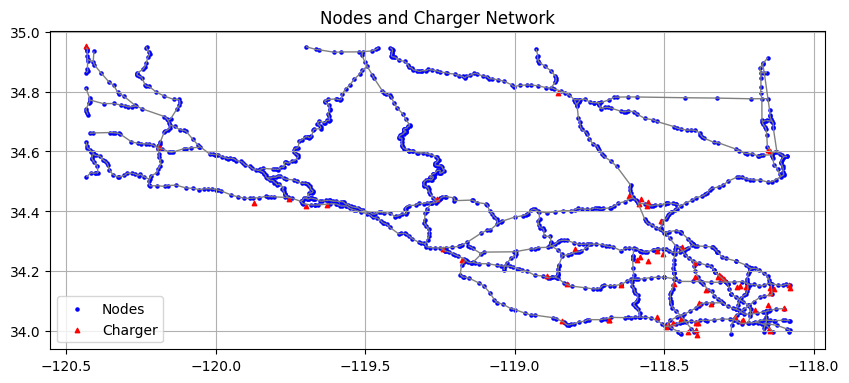

In [26]:
gdf_nodes = gpd.GeoDataFrame(
    df_nodes,
    geometry=gpd.points_from_xy(df_nodes['Longitude'], df_nodes['Latitude'])
)

edge_list = []
for _, edge in df_edges.iterrows():
    node1_coords = gdf_nodes.loc[gdf_nodes['Node'] == edge['Node1']].geometry.values[0]
    node2_coords = gdf_nodes.loc[gdf_nodes['Node'] == edge['Node2']].geometry.values[0]
    edge_list.append(LineString([node1_coords, node2_coords]))

gdf_edges = gpd.GeoDataFrame(geometry=edge_list)

fig, ax = plt.subplots(figsize=(10,10))
gdf_edges.plot(ax=ax,
               linewidth=1,
               color='gray')

gdf_nodes.plot(ax=ax,
               color='blue',
               marker='o',
               label='Nodes',
               markersize=5)

charger_points.plot(ax=ax,
                    color='red',
                    marker='^',
                    label='Charger',
                    markersize=10)

ax.grid(True)
ax.legend()
ax.set_title("Nodes and Charger Network")

plt.show()

In [27]:
gdf_nodes.head()

,Node,Latitude,Longitude,geometry
0,15237,34.946918,-120.433487,POINT (-120.43349 34.94692)
1,15238,34.941998,-120.428612,POINT (-120.42861 34.94200)
2,15239,34.939190,-120.428589,POINT (-120.42859 34.93919)
3,15240,34.933487,-119.508163,POINT (-119.50816 34.93349)
4,15241,34.936329,-119.477669,POINT (-119.47767 34.93633)
...,...,...,...,...
1289,18163,33.996593,-118.082550,POINT (-118.08255 33.99659)
1290,18166,34.017471,-118.157440,POINT (-118.15744 34.01747)
1291,18167,33.997597,-118.135513,POINT (-118.13551 33.99760)
1292,18192,34.008308,-118.166206,POINT (-118.16621 34.00831)


In [28]:
df_charger = pd.concat([charger_points, charger_to_nearest_node], axis=1).drop(columns=["Charger"]).dropna()
df_charger["Nearest_Node"] = np.floor(df_charger["Nearest_Node"]).astype(int)
df_charger.head()

,Supercharger,Street Address,City,Zip,Stalls,kW,GPS,Latitude,Longitude,geometry,Nearest_Node
0,"Buellton, CA",555 McMurray Rd,Buellton,93427,10,150.0,"34.61456, -120.188387",34.614560,-120.188387,POINT (-120.18839 34.61456),15831
1,"Oxnard, CA",2751 Park View Ct,Oxnard,93036,20,150.0,"34.238654, -119.177398",34.238654,-119.177398,POINT (-119.17740 34.23865),17037
2,"Santa Barbara, CA",3943 State St,Santa Barbara,93105,16,250.0,"34.440227, -119.753359",34.440227,-119.753359,POINT (-119.75336 34.44023),16269
3,"Goleta, CA",7004 Market Pl Dr,Goleta,93117,12,250.0,"34.427015, -119.871768",34.427015,-119.871768,POINT (-119.87177 34.42701),16373
4,"Santa Clarita, CA",23975 Newhall Ranch Rd,Santa Clarita,91355,32,250.0,"34.431041, -118.554319",34.431041,-118.554319,POINT (-118.55432 34.43104),16554
...,...,...,...,...,...,...,...,...,...,...,...
63,"Burbank - E Orange Grove Ave, CA",133 E Orange Grove Ave,Burbank,91502,28,250.0,"34.1813, -118.3107",34.181300,-118.310700,POINT (-118.31070 34.18130),17256
64,"Santa Clarita - Newhall Ranch Rd, CA",28273 Newhall Ranch Rd,Santa Clarita,91355,24,250.0,"34.441547, -118.577621",34.441547,-118.577621,POINT (-118.57762 34.44155),16496
65,"Santa Clarita - Magic Mountain Pkwy, CA",24235 Magic Mountain Pkwy,Santa Clarita,91355,16,250.0,"34.41895, -118.559089",34.418950,-118.559089,POINT (-118.55909 34.41895),16556
66,"Chatsworth - Mason Ave, CA",9825 Mason Ave,Chatsworth,91311,20,250.0,"34.248337, -118.580016",34.248337,-118.580016,POINT (-118.58002 34.24834),16949


In [29]:
charger_nodes = df_charger["Nearest_Node"].tolist()

In [30]:
# Create a dictionary to hold the charger nodes segregated by charger type
charger_nodes = {}  # Make sure this is a dictionary, not a list

# Loop over each unique charger type and filter the nodes accordingly
for charger_type in df_charger["kW"].unique():
    # Get the list of nearest nodes for the current charger type
    nodes = df_charger[df_charger["kW"] == charger_type]["Nearest_Node"].tolist()
    
    # Assign the list of nodes to the dictionary with the charger type as the key
    charger_nodes[charger_type] = nodes

In [31]:
# Reversed dictionary to hold the node as the key and the charger type (kW) as the value
charger_nodes_kW = {}

# Loop through the original dictionary
for charger_type, nodes in charger_nodes.items():
    for node in nodes:
        charger_nodes_kW[node] = charger_type

{15831: 150.0,
 17037: 150.0,
 17046: 150.0,
 17343: 150.0,
 16269: 250.0,
 16373: 250.0,
 16554: 250.0,
 17898: 250.0,
 15864: 250.0,
 17970: 250.0,
 16903: 250.0,
 16951: 250.0,
 16890: 250.0,
 17486: 250.0,
 17538: 250.0,
 17807: 250.0,
 15237: 250.0,
 17344: 250.0,
 17314: 250.0,
 18016: 250.0,
 17744: 250.0,
 18166: 250.0,
 18073: 250.0,
 17903: 250.0,
 17304: 250.0,
 16320: 250.0,
 17255: 250.0,
 16694: 250.0,
 16494: 250.0,
 18010: 250.0,
 17246: 250.0,
 18012: 250.0,
 15859: 250.0,
 17902: 250.0,
 18167: 250.0,
 17261: 250.0,
 17311: 250.0,
 16892: 250.0,
 17041: 250.0,
 17742: 250.0,
 17285: 250.0,
 17615: 250.0,
 17784: 250.0,
 16964: 250.0,
 17933: 250.0,
 15528: 250.0,
 17909: 250.0,
 17063: 250.0,
 17250: 250.0,
 16527: 250.0,
 18074: 250.0,
 17809: 250.0,
 17256: 250.0,
 16496: 250.0,
 16556: 250.0,
 16949: 250.0,
 16835: 72.0,
 17485: 72.0,
 17853: 72.0,
 16381: 72.0,
 17284: 72.0,
 18018: 72.0,
 17219: 72.0,
 17969: 72.0,
 17944: 72.0,
 17257: 120.0}

In [32]:
class Car:
    range_L2_cap = {
        "MS": {'range': 2.8, 'cap': 1.75},
        "M3": {'range': 1.3, 'cap': 1},
        "MX": {'range': 2.4, 'cap': 2},
        "MY": {'range': 1.7, 'cap': 1.25}
    }
    
    def __init__(self, model):
        range_calibrate = 1
        self.model = model
        self.range_l2 = Car.range_L2_cap[model]['range'] * range_calibrate
        self.charge_cap = Car.range_L2_cap[model]['cap']
        
    def calculate_penalty(self, charger_kW):
        penalty_l2 = (60 / charger_kW) * self.charge_cap
        return penalty_l2

In [33]:
MS = Car("MS")
M3 = Car("M3")
MX = Car("MX")
MY = Car("MY")

In [34]:
penalty_MS_150kW = MS.calculate_penalty(150)
print(f"Penalty for charging MS at 150 kW charger: {penalty_MS_150kW} L2 units")

# Accessing the range of a specific car
print(f"Range for MS: {MS.range_l2} L2 units")

Penalty for charging MS at 150 kW charger: 0.7000000000000001 L2 units
Range for MS: 2.8 L2 units


In [35]:
def dijkstra_mod(graph, start, charger_nodes, refill_threshold, car):
    node_attr = {
        node: {
            "penalty_dist": float('infinity'),
            "non_charged_dist": float('infinity'),
            "charged_dist": float('infinity'),
            "previous_node": None
        }
        for node in graph
    }
    threshold = car.range_l2

    # Initialize start node distances
    node_attr[start]["non_charged_dist"] = 0
    node_attr[start]["charged_dist"] = 0
    node_attr[start]["penalty_dist"] = 0

    # Priority queue holds tuples of (penalty distance, non-charged distance, charged distance, node)
    priority_queue = [(0, 0, 0, start)]  # (penalty_dist, non_charged_dist, charged_dist, node)
    
    while priority_queue:
        # Pop the node with the smallest penalty distance
        total_distance, total_dist_wo_penalty, current_distance, current_node = heapq.heappop(priority_queue)

        # Skip processing if the popped node's penalty distance is greater than the already found best distance
        if total_distance > node_attr[current_node]["penalty_dist"]:
            continue

        # Handle charging at charger nodes
        if current_distance >= refill_threshold:
            if current_node in charger_nodes:
                kw = charger_nodes[current_node]
                charging_penalty = car.calculate_penalty(kw) * (current_distance/threshold)
                total_distance = total_distance + charging_penalty
                current_distance = 0  # Reset the charged distance
            
        
        for neighbor in graph.neighbors(current_node):
            weight = graph[current_node][neighbor]['weight']
            charged_distance = current_distance + weight
            non_charged_distance = total_dist_wo_penalty + weight
            penalty_distance = total_distance + weight

            # Skip the neighbor if the charged distance exceeds the threshold
            if charged_distance > threshold:
                continue

            # Update neighbor distances if a better path is found
            if penalty_distance < node_attr[neighbor]["penalty_dist"]:
                node_attr[neighbor]["non_charged_dist"] = non_charged_distance
                node_attr[neighbor]["penalty_dist"] = penalty_distance
                node_attr[neighbor]["charged_dist"] = charged_distance
                node_attr[neighbor]["previous_node"] = current_node
                heapq.heappush(priority_queue, (penalty_distance, non_charged_distance, charged_distance, neighbor))
    
    for node, attr in node_attr.items():
        if attr["charged_dist"] == attr["non_charged_dist"]:
            attr["penalty_dist"] = attr["charged_dist"]

    return node_attr

In [36]:
def reconstruct_path(node_attr, start, target):
    path = []
    current_node = target
    while current_node is not None:
        path.append(current_node)
        current_node = node_attr[current_node]["previous_node"]
    path.reverse()
    return path if path[0] == start else None

In [37]:
sample_nodes = df_nodes['Node'].sample(n=2).reset_index(drop=True)
start_node = sample_nodes[0]
target_node = sample_nodes[1]
print("Start Node: ", start_node)
car = M3
refill_threshold_percent = 0.75
refill_threshold = np.floor(car.range_l2 * refill_threshold_percent).astype(int)

Start Node:  17789


In [38]:
node_attr = dijkstra_mod(G, start_node, charger_nodes_kW, refill_threshold, car)

In [40]:
df = pd.DataFrame([
        {
            "Node": node,
            "Post-penalty Dist": attr["penalty_dist"],
            "Distance": attr["non_charged_dist"],
            "Path": None
        }
        for node, attr in node_attr.items()
    ])

df.set_index('Node', inplace=True)
df.sort_index(inplace=True)

In [41]:
df["Path"] = None
for node in G.nodes():
    if node != start_node:
        path = reconstruct_path(node_attr, start_node, node)
        df.at[node, "Path"] = path
df.head()

,Post-penalty Dist,Distance,Path
Node,,,
15237.0,inf,inf,None
15238.0,inf,inf,None
15239.0,inf,inf,None
15240.0,2.719390,2.131998,"[17789, 17788.0, 17757.0, 17758.0, 17701.0, 17..."
15241.0,2.750017,2.162625,"[17789, 17788.0, 17757.0, 17758.0, 17701.0, 17..."
...,...,...,...
18163.0,0.211805,0.202364,"[17789, 17783.0, 17936.0, 17933.0, 17934.0, 17..."
18166.0,0.124322,0.114881,"[17789, 17783.0, 17936.0, 17933.0, 17934.0, 17..."
18167.0,0.165684,0.144475,"[17789, 17783.0, 17936.0, 17933.0, 17934.0, 17..."


In [42]:
df["Penalty"] = df["Post-penalty Dist"]-df["Distance"]
df

,Post-penalty Dist,Distance,Path,Penalty
Node,,,,
15237.0,inf,inf,None,NaN
15238.0,inf,inf,None,NaN
15239.0,inf,inf,None,NaN
15240.0,2.719390,2.131998,"[17789, 17788.0, 17757.0, 17758.0, 17701.0, 17...",0.587392
15241.0,2.750017,2.162625,"[17789, 17788.0, 17757.0, 17758.0, 17701.0, 17...",0.587392
...,...,...,...,...
18163.0,0.211805,0.202364,"[17789, 17783.0, 17936.0, 17933.0, 17934.0, 17...",0.009441
18166.0,0.124322,0.114881,"[17789, 17783.0, 17936.0, 17933.0, 17934.0, 17...",0.009441
18167.0,0.165684,0.144475,"[17789, 17783.0, 17936.0, 17933.0, 17934.0, 17...",0.021209


In [43]:
df[df["Penalty"]>0].head()

,Post-penalty Dist,Distance,Path,Penalty
Node,,,,
15240.0,2.719390,2.131998,"[17789, 17788.0, 17757.0, 17758.0, 17701.0, 17...",0.587392
15241.0,2.750017,2.162625,"[17789, 17788.0, 17757.0, 17758.0, 17701.0, 17...",0.587392
15242.0,2.765464,2.178072,"[17789, 17788.0, 17757.0, 17758.0, 17701.0, 17...",0.587392
15243.0,2.774943,2.187551,"[17789, 17788.0, 17757.0, 17758.0, 17701.0, 17...",0.587392
15249.0,2.911754,2.324362,"[17789, 17788.0, 17757.0, 17758.0, 17701.0, 17...",0.587392
...,...,...,...,...
18163.0,0.211805,0.202364,"[17789, 17783.0, 17936.0, 17933.0, 17934.0, 17...",0.009441
18166.0,0.124322,0.114881,"[17789, 17783.0, 17936.0, 17933.0, 17934.0, 17...",0.009441
18167.0,0.165684,0.144475,"[17789, 17783.0, 17936.0, 17933.0, 17934.0, 17...",0.021209


In [51]:
df[~df["Path"].isnull()].sort_values(by="Distance", ascending=False).head()

,Post-penalty Dist,Distance,Path,Penalty
Node,,,,
16047.0,3.195515,2.608123,"[17789, 17788.0, 17757.0, 17758.0, 17701.0, 17...",0.587392
16046.0,3.178612,2.591220,"[17789, 17788.0, 17757.0, 17758.0, 17701.0, 17...",0.587392
16045.0,3.174013,2.586621,"[17789, 17788.0, 17757.0, 17758.0, 17701.0, 17...",0.587392
16044.0,3.163011,2.575619,"[17789, 17788.0, 17757.0, 17758.0, 17701.0, 17...",0.587392
16043.0,3.155364,2.567972,"[17789, 17788.0, 17757.0, 17758.0, 17701.0, 17...",0.587392


In [45]:
target_node_path = df.loc[target_node]["Path"]
target_node_path_coords = [gdf_nodes.loc[gdf_nodes["Node"] == node].geometry.values[0] for node in target_node_path]
gdf_shortest_path = gpd.GeoDataFrame(geometry=[LineString(target_node_path_coords)])

,geometry
0,"LINESTRING (-118.23305 34.05664, -118.24319 34..."


In [46]:
penalty = df.loc[target_node]["Penalty"]
shortest_path_distance = df.loc[target_node]["Distance"]

print("Shortest path distance: ", np.round(shortest_path_distance,4))
print("Charging Penalty: ", np.round(penalty,4))

Shortest path distance:  0.2762
Charging Penalty:  0.0274


Start Node:  17789
Target Node:  17235
Car Model:  M3
Shortest path distance:  0.2762
Charging Penalty:  0.0274


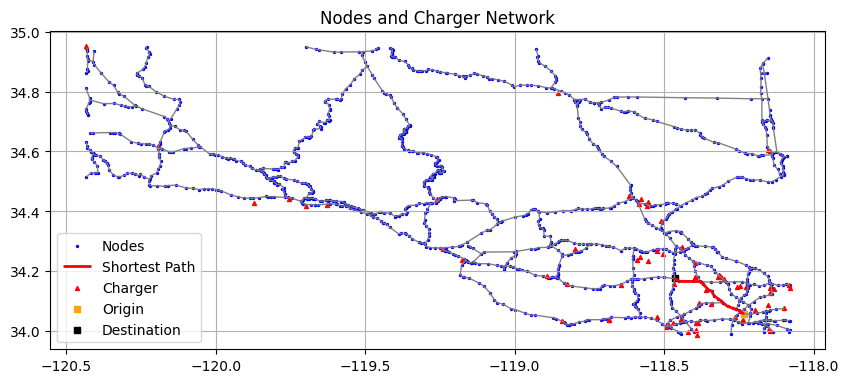

In [55]:
print("Start Node: ", start_node)
print("Target Node: ", target_node)
print("Car Model: ",car.model)
if shortest_path_distance < float('inf'):
    print("Shortest path distance: ", np.round(shortest_path_distance,4))
    print("Charging Penalty: ", np.round(penalty,4))
else:
    print("No path available")

gdf_nodes = gpd.GeoDataFrame(
    df_nodes,
    geometry=gpd.points_from_xy(df_nodes['Longitude'], df_nodes['Latitude'])
)

edge_list = []
for _, edge in df_edges.iterrows():
    node1_coords = gdf_nodes.loc[gdf_nodes['Node'] == edge['Node1']].geometry.values[0]
    node2_coords = gdf_nodes.loc[gdf_nodes['Node'] == edge['Node2']].geometry.values[0]
    edge_list.append(LineString([node1_coords, node2_coords]))

gdf_edges = gpd.GeoDataFrame(geometry=edge_list)

fig, ax = plt.subplots(figsize=(10,10))
gdf_edges.plot(ax=ax,
               linewidth=1,
               color='gray')

gdf_nodes.plot(ax=ax,
               color='blue',
               marker='o',
               label='Nodes',
               markersize=2)

gdf_shortest_path.plot(ax=ax, linewidth=2, color='red', label='Shortest Path')

charger_points.plot(ax=ax,
                    color='red',
                    marker='^',
                    label='Charger',
                    markersize=8)

# origin_coords = gdf_nodes.loc[gdf_nodes['Node'] == start_node].geometry.values[0]
# destination_coords = gdf_nodes.loc[gdf_nodes['Node'] == target_node].geometry.values[0]

gdf_nodes[gdf_nodes['Node'] == start_node].plot(ax=ax, color='orange', marker='s', label='Origin', markersize=20)
gdf_nodes[gdf_nodes['Node'] == target_node].plot(ax=ax, color='black', marker='s', label='Destination', markersize=20)

ax.grid(True)
ax.legend()
ax.set_title("Nodes and Charger Network")

plt.show()

In [59]:
# Create GeoDataFrame for nodes
gdf_nodes = gpd.GeoDataFrame(
    df_nodes,
    geometry=gpd.points_from_xy(df_nodes['Longitude'], df_nodes['Latitude'])
)

# Create edges
edge_list = []
for _, edge in df_edges.iterrows():
    node1_coords = gdf_nodes.loc[gdf_nodes['Node'] == edge['Node1']].geometry.values[0]
    node2_coords = gdf_nodes.loc[gdf_nodes['Node'] == edge['Node2']].geometry.values[0]
    edge_list.append(LineString([node1_coords, node2_coords]))

gdf_edges = gpd.GeoDataFrame(geometry=edge_list)

# Get origin location coordinates
origin = gdf_nodes.loc[gdf_nodes['Node'] == start_node].iloc[0]

# Create Folium map
map_center = [origin.geometry.y, origin.geometry.x]  # Center map closer to origin
m = folium.Map(location=map_center, zoom_start=12)  # Zoom in more

# Add edges
folium.GeoJson(
    gdf_edges.__geo_interface__,
    style_function=lambda x: {'color': 'gray', 'weight': 1}
).add_to(m)

# Add nodes
for _, node in gdf_nodes.iterrows():
    folium.CircleMarker(
        [node.geometry.y, node.geometry.x],
        radius=2,
        color='blue',
        fill=True,
        fillColor='blue',
        fillOpacity=1
    ).add_to(m)

# Add shortest path
folium.GeoJson(
    gdf_shortest_path.__geo_interface__,
    style_function=lambda x: {'color': 'red', 'weight': 10}
).add_to(m)

# Add charger points with color based on kW
for _, charger in df_charger.iterrows():
    coordinates = charger['GPS'].split(', ')
    lat, lon = float(coordinates[0]), float(coordinates[1])
    kw = charger['kW']
    zip_code = charger['Zip']
    stalls = charger['Stalls']
    
    if kw == 250:
        marker_color = 'red'
    elif kw == 150:
        marker_color = 'blue'
    elif kw in [120, 122, 125, 120]:
        marker_color = 'gray'
    elif kw == 72:
        marker_color = 'beige'
    else:
        marker_color = 'green'
    
    folium.Marker(
        [lat, lon],
        popup=f"Zip: {zip_code},\nStalls: {stalls},\n{np.floor(kw).astype(int)} kW\n({lat}, {lon})",
        icon=folium.Icon(color=marker_color, icon='bolt', prefix='fa')
    ).add_to(m)


# Add origin and destination
folium.Marker(
    [origin.geometry.y, origin.geometry.x],
    icon=folium.Icon(color='orange', icon='play', prefix='fa'),
    popup='Origin'
).add_to(m)

destination = gdf_nodes.loc[gdf_nodes['Node'] == target_node].iloc[0]

folium.Marker(
    [destination.geometry.y, destination.geometry.x],
    icon=folium.Icon(color='black', icon='flag-checkered', prefix='fa'),
    popup='Destination'
).add_to(m)

# Prepare the text content for the box
info_box_html = f'''
<div style="
    position: fixed;
    top: 10px; right: 10px; 
    width: 250px;
    height: auto;
    padding: 10px;
    background-color: white;
    border: 2px solid gray;
    z-index: 1000;
    font-size: 14px;
    font-family: Arial, sans-serif;
">
    <b>Start Node:</b> {start_node}<br>
    <b>Target Node:</b> {target_node}<br>
    <b>Car Model:</b> {car.model}<br>
'''

if shortest_path_distance < float('inf'):
    info_box_html += f'''
    <b>Path Distance:</b> {np.round(shortest_path_distance, 4)}<br>
    <b>Charging Penalty:</b> {np.round(penalty, 4)}
    '''
else:
    info_box_html += f'''
    <b style="color: red;">No path available</b>
    '''

info_box_html += '</div>'

# Add the information box to the map
m.get_root().html.add_child(folium.Element(info_box_html))


# Add layer control and title
folium.LayerControl().add_to(m)
title_html = '''
             <h3 align="center" style="font-size:16px"><b>Shortest path for charge-constrained EV</b></h3>
             '''
m.get_root().html.add_child(folium.Element(title_html))

# Display the map
m

M3
